In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fnmatch import fnmatch
import pandas as pd
import numpy as np
import time

sns.set(style='white')


color_names = ["black",
               "windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

In [2]:
# accumulate fit random seed in the /src director
pattern = "*.csv"
outfilenames = []
for path, subdirs, files in os.walk('./measure_out/'):
    for name in files:
        if fnmatch(name, pattern):
            outfilenames.append(os.path.join(path, name)) 


dataframes = [pd.read_csv(df) for df in outfilenames]
if len(dataframes) > 0:
    disentangle_measuredf_concat = pd.concat(dataframes)
    disentangle_measuredf_concat.to_csv('disentangle_measure_agg_'+str(int(time.time()*1e6))+'.csv')


In [3]:
# disentangle_measuredf_concat = pd.read_csv('disentangle_measure_agg_1630880910020322.csv')

In [4]:
disentangle_measuredf_concat.mean()

Unnamed: 0                                  0.500000
avg_corr_coef                               0.556964
IOSS                                        0.727333
IRS                                         0.794082
gaussian_total_correlation                  2.686562
gaussian_wasserstein_dependency             0.297378
IOSS_classify                               0.959500
IRS_classify                                1.000000
gaussian_total_correlation_classify         0.295000
gaussian_wasserstein_dependency_classify    0.677000
avg_corr_coef_classify                      0.004500
dtype: float64

In [5]:
datasets = ['mpi3d', 'smallnorb', 'dsprites', 'cars3d']
metric_names = dict({'IOSS':'IOSS', 'IRS':'IRS', \
                     'gaussian_total_correlation':'Total Correlation', \
                    'gaussian_wasserstein_dependency': 'Wasserstein Dependency'})

In [6]:
class_res = pd.concat([disentangle_measuredf_concat[disentangle_measuredf_concat['dataset']==datasetname][[\
            'IOSS_classify', 'gaussian_total_correlation_classify', \
            'gaussian_wasserstein_dependency_classify', 'IRS_classify']].mean() for datasetname in datasets], axis=1)
class_res_std = pd.concat([disentangle_measuredf_concat[disentangle_measuredf_concat['dataset']==datasetname][[\
            'IOSS_classify', 'gaussian_total_correlation_classify', \
            'gaussian_wasserstein_dependency_classify', 'IRS_classify']].std() for datasetname in datasets], axis=1)

In [7]:
class_res.columns = datasets
class_res = class_res.T
class_res.columns = ['IOSS (this paper)', 'Total Correlation', 'Wasserstein Dependency', 'IRS (oracle)']
class_res = class_res.T

In [8]:
class_res

,mpi3d,smallnorb,dsprites,cars3d
IOSS (this paper),0.998,0.968,0.980,0.892
Total Correlation,0.858,0.070,0.162,0.090
Wasserstein Dependency,0.956,0.478,0.310,0.964
IRS (oracle),1.000,1.000,1.000,1.000


In [9]:
print(class_res.to_latex(float_format="%.3f"))  

\begin{tabular}{lrrrr}
\toprule
{} &  mpi3d &  smallnorb &  dsprites &  cars3d \\
\midrule
IOSS (this paper)      &  0.998 &      0.968 &     0.980 &   0.892 \\
Total Correlation      &  0.858 &      0.070 &     0.162 &   0.090 \\
Wasserstein Dependency &  0.956 &      0.478 &     0.310 &   0.964 \\
IRS (oracle)           &  1.000 &      1.000 &     1.000 &   1.000 \\
\bottomrule
\end{tabular}



In [10]:
class_res_std.columns = datasets
class_res_std = class_res_std.T
class_res_std.columns = ['IOSS (this paper) std', 'Total Correlation std', 'Wasserstein Dependency std', 'IRS (oracle) std']
class_res_std = class_res_std.T

In [11]:
class_res_std

,mpi3d,smallnorb,dsprites,cars3d
IOSS (this paper) std,0.044699,0.176088,0.140070,0.310536
Total Correlation std,0.349225,0.255275,0.368635,0.286325
Wasserstein Dependency std,0.205198,0.499766,0.462725,0.186383
IRS (oracle) std,0.000000,0.000000,0.000000,0.000000


In [12]:
class_res_all = pd.concat([class_res, class_res_std], axis=0)

In [13]:
class_res_all = class_res_all.sort_index()

In [14]:
print(class_res_all.to_latex(float_format="%.3f"))  

\begin{tabular}{lrrrr}
\toprule
{} &  mpi3d &  smallnorb &  dsprites &  cars3d \\
\midrule
IOSS (this paper)          &  0.998 &      0.968 &     0.980 &   0.892 \\
IOSS (this paper) std      &  0.045 &      0.176 &     0.140 &   0.311 \\
IRS (oracle)               &  1.000 &      1.000 &     1.000 &   1.000 \\
IRS (oracle) std           &  0.000 &      0.000 &     0.000 &   0.000 \\
Total Correlation          &  0.858 &      0.070 &     0.162 &   0.090 \\
Total Correlation std      &  0.349 &      0.255 &     0.369 &   0.286 \\
Wasserstein Dependency     &  0.956 &      0.478 &     0.310 &   0.964 \\
Wasserstein Dependency std &  0.205 &      0.500 &     0.463 &   0.186 \\
\bottomrule
\end{tabular}



In [15]:
results = []
for datasetname in datasets:
    disentangled = disentangle_measuredf_concat[\
            (disentangle_measuredf_concat['dataset']==datasetname) & \
            (disentangle_measuredf_concat['disentanglement']=='disentangled')][['IOSS', 'IRS', \
            'gaussian_total_correlation', 'gaussian_wasserstein_dependency']].stack().reset_index().set_index(\
            'level_0').rename(columns={'level_1':'metric',0:'score'})
    disentangled['dataset'] = datasetname
    disentangled['disentanglement'] = 'disentangled'

    entangled = disentangle_measuredf_concat[\
            (disentangle_measuredf_concat['dataset']==datasetname) & \
            (disentangle_measuredf_concat['disentanglement']=='entangled')][['IOSS', 'IRS', \
            'gaussian_total_correlation', 'gaussian_wasserstein_dependency']].stack().reset_index().set_index(\
            'level_0').rename(columns={'level_1':'metric',0:'score'})
    entangled['dataset'] = datasetname
    entangled['disentanglement'] = 'entangled'
    results.append(pd.concat([disentangled, entangled]))

IOSS mpi3d
IRS mpi3d
gaussian_total_correlation mpi3d
gaussian_wasserstein_dependency mpi3d
IOSS smallnorb
IRS smallnorb
gaussian_total_correlation smallnorb
gaussian_wasserstein_dependency smallnorb
IOSS dsprites
IRS dsprites
gaussian_total_correlation dsprites


<ipython-input-16-49ef5b2ec59b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4,3))


gaussian_wasserstein_dependency dsprites
IOSS cars3d
IRS cars3d
gaussian_total_correlation cars3d
gaussian_wasserstein_dependency cars3d


<Figure size 288x216 with 0 Axes>

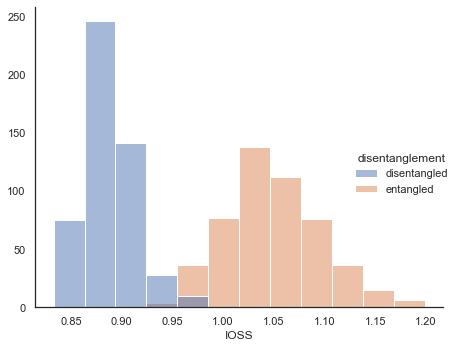

<Figure size 288x216 with 0 Axes>

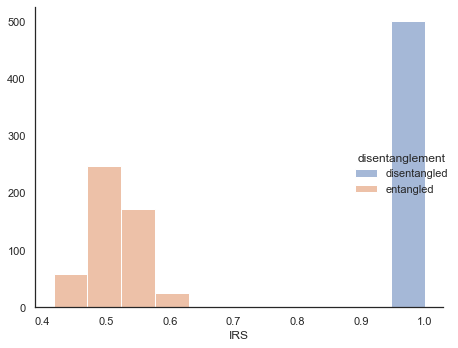

<Figure size 288x216 with 0 Axes>

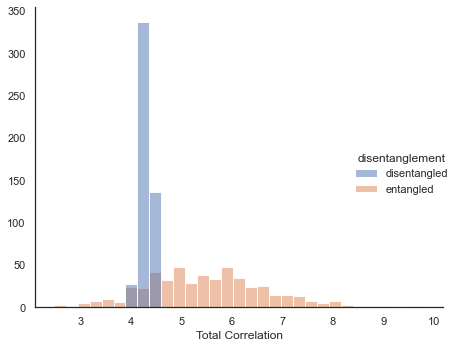

<Figure size 288x216 with 0 Axes>

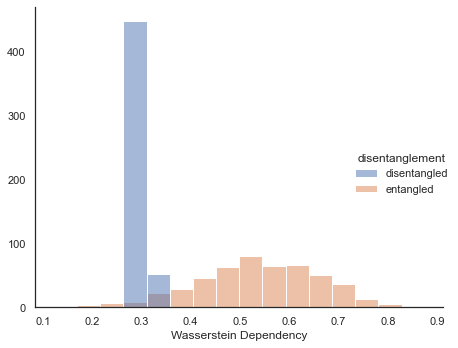

<Figure size 288x216 with 0 Axes>

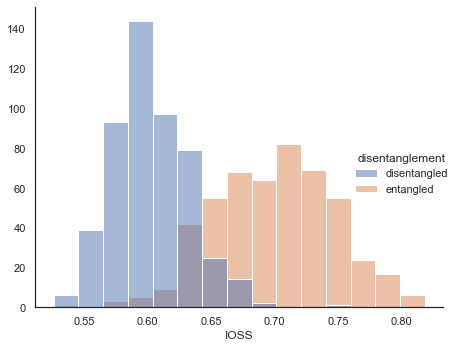

<Figure size 288x216 with 0 Axes>

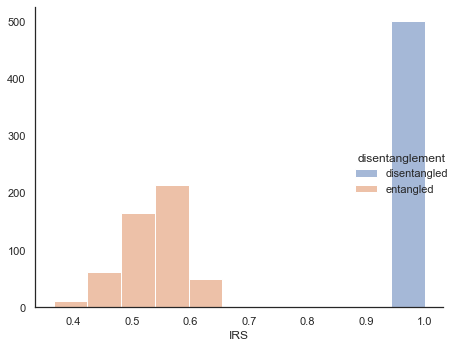

<Figure size 288x216 with 0 Axes>

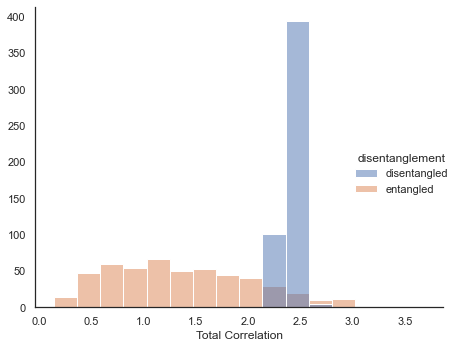

<Figure size 288x216 with 0 Axes>

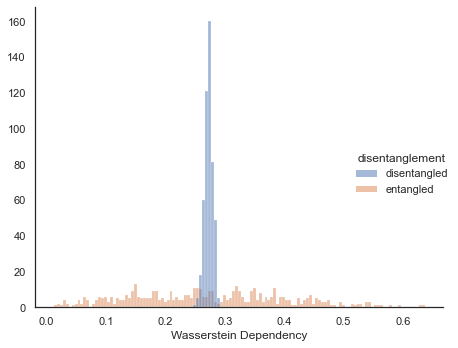

<Figure size 288x216 with 0 Axes>

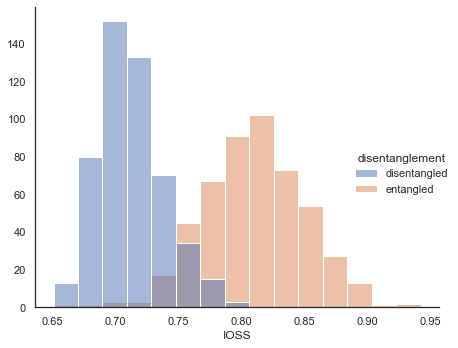

<Figure size 288x216 with 0 Axes>

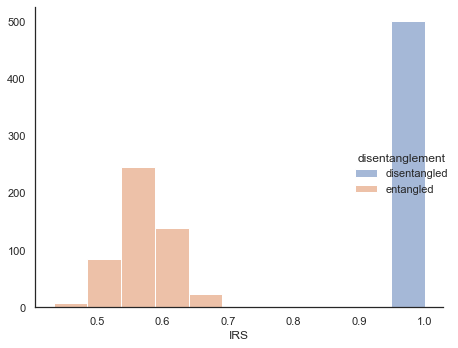

<Figure size 288x216 with 0 Axes>

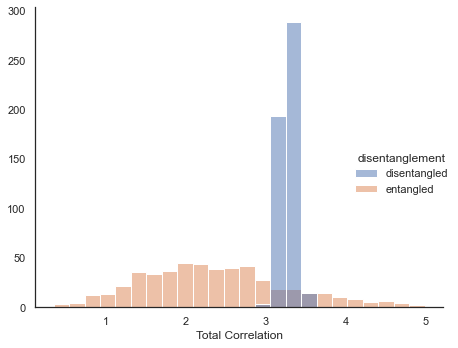

<Figure size 288x216 with 0 Axes>

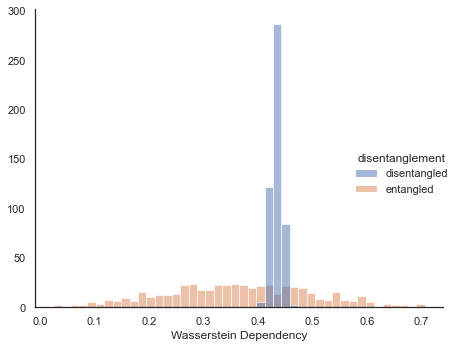

<Figure size 288x216 with 0 Axes>

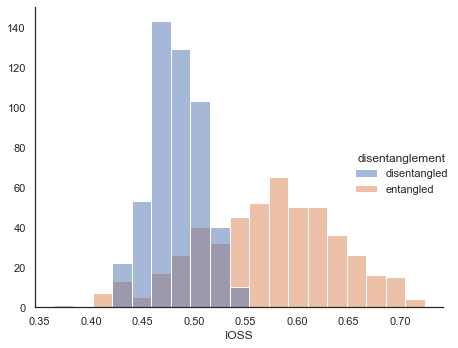

<Figure size 288x216 with 0 Axes>

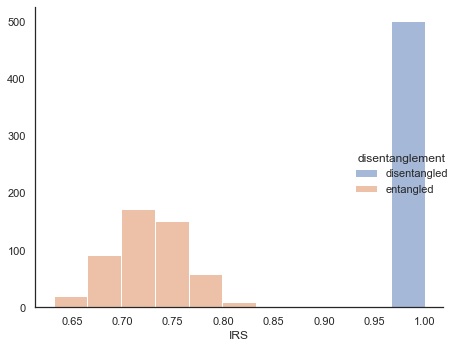

<Figure size 288x216 with 0 Axes>

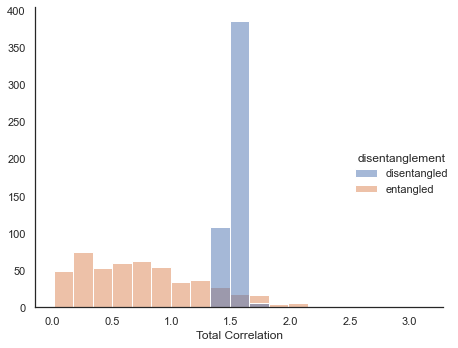

<Figure size 288x216 with 0 Axes>

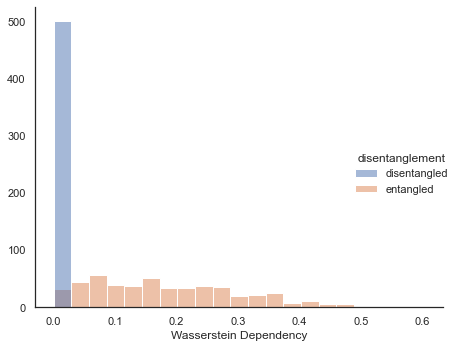

In [16]:

for j in range(len(results)):
    for metric in ['IOSS', 'IRS', 'gaussian_total_correlation', 'gaussian_wasserstein_dependency']:
        print(metric, results[j]['dataset'].iloc[0])
        plt.figure(figsize=(4,3))
        g = sns.displot(results[j][results[j]['metric']==metric], x="score", hue="disentanglement")
        g.set(xlabel=metric_names[metric])
        g.set(ylabel='')
        plt.tight_layout()
        plt.savefig('disentangle_measure_histogram_'+metric+results[j]['dataset'].iloc[0]+'.pdf')